# Includes

In [260]:
import random
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import numpy as np

# Initialisation des paramètres

In [261]:
Npop = 500
Sp = 2
alpha = 0.7
epsilon = 1e-6
Gmax = 2000
pmut = 1
Ntour = 4
xmax = 1
xmin = 0

# Initialisation variables

In [262]:
pop_anim = []

population = []
best = []
worst = []
average = []
generation =[0]

# Création de la classe individu

In [263]:
class Individu:
    def __init__(self, x1, x2):
        self.x = [x1,x2]
        self.f = [0,0]

    def evaluation(self):
        # === Deb1 === non convexe
        def f (x1):
            return 4*x1
        
        def g (x2):
            return 4 - 3*math.exp(-((x2-0.2)/0.02)**2) if 0 <= x2 <= 0.4 else 4 - 2*math.exp(-((x2-0.7)/0.2)**2)
                
        def h(x1, x2):
            alpha = 0.25+3.75*(g(x2)-1)
            beta = 1
            return 1-(f(x1)/beta/g(x2))**alpha if f(x1)<=beta*g(x2) else 0
        
        self.f[0] = f(self.x[0])
        self.f[1] = g(self.x[1])*h(self.x[0], self.x[1])

        # === Deb3 === multifrontale
        # def f (x1):
        #     return x1
        
        # def g (x2):
        #     return 2 - math.exp(-((x2-0.2)/0.04)**2)-0.8*math.exp(-((x2-0.6)/0.4)**2)
        
        # def h(x1):
        #     return 1/f(x1)
        
        # self.f[0] = f(self.x[0])
        # self.f[1] = g(self.x[1])*h(self.x[0])

        # === Hanne 1 ===
        #self.f[0] = self.x[0]
        #self.f[1] = self.x[1]

        # === Hanne 2 ===
        # self.f[0] = self.x[0]**2
        # self.f[1] = self.x[1]**2

        # === Hanne 3 ===
        # self.f[0] = self.x[0]**(1/2)
        # self.f[1] = self.x[1]**(1/2)

        # === Hanne 5 ===
        # self.f[0] = int(self.x[0]) + 0.5 + (self.x[0]- int(self.x[0]))*math.sin(2*math.pi*(self.x[1]-int(self.x[1])))
        # self.f[1] = int(self.x[1]) + 0.5 + (self.x[0]- int(self.x[0]))*math.cos(2*math.pi*(self.x[1]-int(self.x[1])))

# Création des fonctions

In [264]:
# Affichage de la population
def plot_population(population, generation, ax):
    ax.clear()
    ax.plot([individu.f[0] for individu in population], [individu.f[1] for individu in population], 'ro')
    ax.set_ylabel('f2')
    ax.set_xlabel('f1')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    ax.set_title(f'Population jusqu\'à la génération {generation[-1]}')

def ranking(population, Npop):
    ranking = np.zeros(Npop)
    for i in range(Npop):
        for j in range(Npop):
            if i!=j:
                if population[j].f[0] <= population[i].f[0] and population[j].f[1] <= population[i].f[1]:
                    ranking[i] += 1
    
    return ranking

def plot_pareto(population, Npop):
    rank = ranking(population, Npop)
    pareto = []

    for i in range(Npop):
        if rank[i] == 0:
            pareto.append(population[i])

    # Plot points from the Pareto front
    plt.plot([individu.f[0] for individu in pareto], [individu.f[1] for individu in pareto], 'ro', label='Pareto Front')

    # Plot the curve defined by f1 and f2
    # f1 = np.linspace(0.1, 1, 100)
    # f2 = (2-math.exp(-25)-0.8*math.exp(-0.25))/f1
    # plt.plot(f1, f2, color='blue', label='Curve f1-f2')

    # Set labels and title
    plt.ylabel('f2')
    plt.xlabel('f1')
    plt.xlim(0, 1)
    plt.ylim(0.646, 10)
    plt.title('Front de Pareto')

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()


# Initialisation de la population
def initialisation(population, Npop):
    for i in range(Npop):
        x1 = random.uniform(xmin, xmax)
        x2 = random.uniform(xmin, xmax)
        population.append(Individu(x1, x2))

# Evaluation de la population
def evaluation(population):
    for individu in population:
        individu.evaluation()

# Sélection des parents
def selection_tournoi(population, Ntour):
    new_population = []
    for i in range(Npop):
        best = None
        for j in range(Ntour):
            individu = random.choice(population)
            if best is None or individu.f < best.f:
                best = individu
        new_population.append(best)
    population.clear()
    for individu in new_population:
        population.append(individu)

def selection_classement(population, Npop, Sp):
    new_population = []
    ps = [0]
    rank = ranking(population, Npop)
    
    for i in range(Npop):
        # Calcul de ps
        ps.append(ps[i] + (1/Npop)*(Sp-2*(Sp-1)*(rank[i]/(Npop-1))))

    interval = 1/Npop
    start = random.uniform(0, interval)
    i = 0
    while len(new_population) < Npop:
        cursor = start + len(new_population)*interval
        if cursor <= ps[i+1]:
            new_population.append(population[i])
        else:
            i = i+1

    population.clear()
    for individu in new_population:
        population.append(individu)

# Croisement
def croisement(population, Npop):
    new_population = []
    while len(new_population) < Npop :
         # Tirer au hasard deux individus
        parent1 = random.choice(population)
        population.remove(parent1)
        parent2 = random.choice(population)
        population.remove(parent2)

        # calcul de lambda
        u = random.uniform(0,1)
        Y = u*(1+2*alpha)-alpha

        # Calcul des enfants
        x1_1 = Y*parent1.x[0] + (1-Y)*parent2.x[0]
        x2_1 = Y*parent1.x[1] + (1-Y)*parent2.x[1]
        x1_2 = (1-Y)*parent1.x[0] + Y*parent2.x[0]
        x2_2 = (1-Y)*parent1.x[1] + Y*parent2.x[1]

        # Ajouter les enfants à la nouvelle population
        if x1_1 > xmax or x1_1 < xmin or x2_1 > xmax or x2_1 < xmin:
            if random.choice([True, False]):
                new_population.append(parent1)
            else:
                new_population.append(parent2)
        else:
            new_population.append(Individu(x1_1,x2_1))

        if x1_2 > xmax or x1_2 < xmin or x2_2 > xmax or x2_2 < xmin:
            if random.choice([True, False]):
                new_population.append(parent1)
            else:
                new_population.append(parent2)
        else:
            new_population.append(Individu(x1_2,x2_2))

    population.clear()
    for individu in new_population:
        population.append(individu)

# Mutation
def mutation(population, pmut, generation, xmax, xmin, Gmax):
    for individu in population:
        if random.uniform(0,100) < pmut:
            xi = random.choice([0,1])
            delta = random.choice([-1,1])
            if delta == 1:
                pas = random.uniform(0,1)*(xmax-individu.x[xi])*(1-generation[-1]/Gmax)
            else:
                pas = random.uniform(0,1)*(individu.x[xi]-xmin)*(1-generation[-1]/Gmax)
            individu.x[xi] = individu.x[xi] + delta*pas

# Programme principal

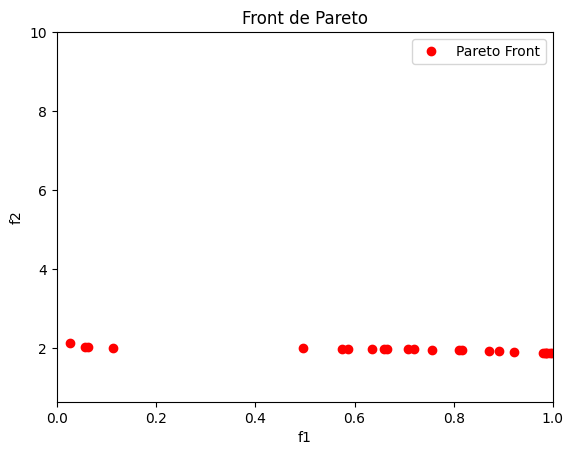

In [265]:
fig, ax = plt.subplots()

# Initialisation de la population
initialisation(population, Npop)

#pop_anim.append(population.copy())

# Evaluation de la population
evaluation(population)

# Boucle principale

for i in range(Gmax):
    # Incrémentation du nombre de génération
    generation.append(generation[-1] + 1)

    # Sélection des parents
    #selection_tournoi(population, Ntour)
    selection_classement(population, Npop, Sp)

    # Croisement
    croisement(population, Npop)

    # Mutation
    mutation(population, pmut, generation, xmax, xmin, Gmax)

    #pop_anim.append(population.copy())

    # Evaluation de la population
    evaluation(population)

# Animation de la population
#ani = FuncAnimation(fig, plot_population, frames=pop_anim, fargs=(generation, ax), interval=100, repeat=False)
#ani.save('evolution_population.gif', writer='pillow')

plot_pareto(population, Npop)